# Data extraction, transformation, and loading into a JSON file
This is part of the project described in <https://github.com/amchagas/OSH_papers_DB>, check the project readme for more details.

This notebook loads data sources and merges them in a single compressed JSON file.

In [26]:
import os
import re
import numpy as np
import pandas as pd
import rispy
import matplotlib.pyplot as plt
from pathlib import Path
from project_definitions import baseDir, dataSourceDir, dataOutDir, figDir, allDataFile
from project_definitions import store_data, load_data
from pprint import pprint
import html
from nltk.metrics.distance import edit_distance

## Sources

In [2]:
scieloSource = {
    'paths': [dataSourceDir / x for x in ("scielo.ris",)],
    'rispy_args': {},
    'col_rename': {'journal_name': 'publication_name'},
    'transforms': [],
}
scopusSource = {
    'paths': [dataSourceDir / x for x in ("scopus.ris",)],
    'rispy_args': {},
    'col_rename': {},
    'transforms': [],
}
wosSource = {
    'paths': [dataSourceDir / x for x in ("wos1-500.ciw", "wos501-973.ciw")],
    'rispy_args': {'implementation': 'wok'},
    'col_rename': {'publication_year': 'year', 'document_title': 'title'},
    'transforms': [],
}

In [3]:
def load_source(dataSource):
    dfs = []
    for path in dataSource['paths']:
        with path.open() as f:
            df = pd.DataFrame(rispy.load(f, **dataSource['rispy_args']))
        df['__source'] = path.name
        dfs.append(df)
    cdf = pd.concat(dfs, join='outer', ignore_index=True)
    cdf = cdf.rename(columns=dataSource['col_rename'])
    for trans in dataSource['transforms']:
        cdf = cdf.transform(trans)
    return cdf.sort_index(axis=1)

In [4]:
scieloData = load_source(scieloSource)

In [5]:
scopusData = load_source(scopusSource)

In [6]:
wosData = load_source(wosSource)

In [18]:
allDataList = [scieloData, scopusData, wosData]

In [19]:
allData = pd.concat(allDataList, join='outer', ignore_index=True)

In [20]:
store_data(allData, allDataFile)

In [21]:
assert allData.equals(load_data(allDataFile))

In [22]:
allData.describe()

,__source,abstract,alternate_title1,authors,database_provider,date,doi,end_page,file_attachments1,id,...,research_areas,researcher_id,source_abbreviation_29c,special_issue,supplement,total_times_cited_count,usage_count_180,usage_count_2013,wos_categories,wos_core_collection_cited_count
count,2475,2414,1499,2438,20,20,1880,991,19,20,...,972,455,752,38,5,973,973,973,972,973
unique,4,2390,927,2344,1,19,1330,645,19,20,...,217,407,440,2,3,66,14,78,349,65
top,scopus.ris,The reasons for the inferior performance of ma...,HardwareX,"[Pearce, J.M.]",http://www.scielo.org/,2017-09,10.5935/0100-4042.20160020,6,http://www.scielo.br/pdf/rbef/v37n1/0102-4744-...,S0100-40422013000800023-scl,...,Engineering,"Pearce, J.M/C-9240-2013; Pearce, Joshua M/D-20...",SENSORS-BASEL,SI,1,0,0,0,"Engineering, Electrical & Electronic",0
freq,1482,3,46,12,20,2,3,14,1,1,...,116,13,40,37,3,378,735,263,46,379


In [23]:
x = allData.copy()
del x["__source"]
x = x.groupby('doi').agg(
    lambda x: x.agg(
        lambda y: np.nan if y.isna().all() else y[y.map(len, na_action='ignore').idxmax()],
    )
)

In [174]:
class Match:
    def __init__(self, series, threshold):
        self.s = series
        self.threshold = threshold
        self.match_index = {}
    def match(self, x):
        x = self.s.loc[x]
        if x in self.match_index:
            return self.match_index[x]
        for m, idx in self.match_index.items():
            if self.threshold == 0:
                if x == m:
                    return idx
            elif edit_distance(x, m) <= self.threshold:
                return idx
        self.match_index[x] = len(self.match_index)
        return self.match_index[x]

In [211]:
all_nodoi = allData[~allData.doi.isin(x.index)]
a = (
    all_nodoi
    .title
    .str.lower()
    .str.replace(r'[^\s\w]', ' ', regex=True)
    .str.replace(r'(?<=\s)\S{,5}(?=\s)', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)
a = a.groupby(Match(a, 5).match)

In [212]:
aa = a.agg(list)[a.size()>=2].to_dict()

In [213]:
all_nodoi = allData[~allData.doi.isin(x.index)]
b = (
    all_nodoi
    .title
    .str.lower()
    .str.replace(r'[^\s\w]', ' ', regex=True)
    .str.replace(r'(?<=\s)\S{,5}(?=\s)', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)
b = b.groupby(Match(b, 0).match)

In [214]:
bb = b.agg(list)[b.size()>=2].to_dict()

In [215]:
set(x for x in aa.values() for x in x).difference(x for x in bb.values() for x in x)

set()

In [224]:
y = allData[~allData.doi.isin(x.index)].copy()
del y["__source"]
y = y.groupby(b.ngroup()).agg(
    lambda x: x.agg(
        lambda y: np.nan if y.isna().all() else y[y.map(len, na_action='ignore').idxmax()],
    )
)

In [230]:
udata = pd.concat([x,y])

# bof

In [61]:
all_nodoi = allData[~allData.doi.isin(x.index)]
a = (all_nodoi
 .title
 .str.lower()
 .str.replace(r'[^\s\w]', ' ', regex=True)
 .str.replace(r'(?<=\s)\S{,5}(?=\s)', '', regex=True)
 .str.replace(r'\s+', ' ', regex=True)
 .str.strip()
)
a.value_counts().value_counts()
idxa = np.concatenate([a.groupby(a).groups[x] for x in a.groupby(a).size().pipe(lambda x: x[x==2]).index])
a[idxa]
b = (all_nodoi
 .title
 .str.lower()
 .str.replace(r'[^\s\w]', ' ', regex=True)
# .str.replace(r'(?<=\s)\S{,8}(?=\s)', '', regex=True)
 .str.replace(r'\s+', ' ', regex=True)
 .str.strip()
)
b.value_counts().value_counts()
idxb = np.concatenate([b.groupby(b).groups[x] for x in b.groupby(b).size().pipe(lambda x: x[x==2]).index])
b[idxb]
idx = allData.title.loc[set(idxb).symmetric_difference(idxa)].index
allData.title[idx].to_dict(), b[idx], a[idx]

({2098: 'Low-cost Intelligent Static Gesture Recognition System',
  1987: 'Low-Cost Wireless Intelligent Two Hand Gesture Recognition System'},
 2098    low intelligent recognition system
 1987    low intelligent recognition system
 Name: title, dtype: object,
 2098    low intelligent static gesture recognition system
 1987    low wireless intelligent gesture recognition s...
 Name: title, dtype: object)

## CSV sources

In [ ]:
plosData = pd.read_csv('https://raw.githubusercontent.com/amchagas/open-source-toolkit/main/plos-items.csv')

In [ ]:
sel_article = plosData["Content Type (URL items only - Research Article, Web Article, Commentary, Video, Poster)"].eq("Research Article")
sel_hardware = plosData["Hardware or software"].eq("hardware")
plosData = plosData.loc[sel_article & sel_hardware]
assert not plosData["URI (DOI or URL)"].isna().any()
plosData['Title (URL items only)'] = plosData['Title (URL items only)'].str.strip()
plosData

In [ ]:
plos2bibtex = {
    "URI (DOI or URL)": "doi",
    "": "",
}

In [ ]:
sel_new_doi = ~plosData["URI (DOI or URL)"].isin(allData.doi.values)
sel_new_doi.sum()

In [ ]:
sel_new_title = ~plosData["Title (URL items only)"].isin(allData.title.values)
sel_new_title.sum()

In [ ]:
# Same titles, different DOIs
x = plosData[["URI (DOI or URL)", "Title (URL items only)"]].loc[sel_new_doi & ~sel_new_title]
x['doi'] = [
    allData["doi"].loc[
        allData['title'].eq(y)
    ].squeeze()
    for y in x["Title (URL items only)"]
]
x

In [ ]:
# Same DOI, different Titles
pprint(plosData["Title (URL items only)"].loc[~sel_new_doi & sel_new_title])
print()
pprint(allData["title"].loc[
    allData["doi"].eq('10.1371/journal.pone.0023783')
])

# All done, now just mess around

In [303]:
data = udata

In [304]:
print(data.shape)
print(data.columns)

(1887, 86)
Index(['abstract', 'alternate_title1', 'authors', 'database_provider', 'date',
       'end_page', 'file_attachments1', 'id', 'issn', 'journal_name',
       'keywords', 'language', 'name_of_database', 'number', 'start_page',
       'title', 'translated_title', 'type_of_reference', 'url', 'volume',
       'year', 'author_address', 'custom2', 'custom3', 'custom7', 'notes',
       'place_published', 'publisher', 'secondary_authors', 'secondary_title',
       'short_title', 'type_of_work', 'accession_number', 'article_number',
       'author_full_name', 'author_keywords', 'beginning_page', 'book_authors',
       'book_authors_full_name', 'book_doi', 'book_group_authors',
       'book_series_title', 'cited_reference_count', 'conference_date',
       'conference_host', 'conference_location', 'conference_sponsors',
       'conference_title', 'date_generated', 'document_delivery_number',
       'document_type', 'early_access_date', 'editors', 'eissn',
       'email_address', 'ending_

In [305]:
article_data = data.loc[data["type_of_reference"].eq('JOUR') | data["publication_type"].eq('J')]
print(article_data.shape)

(718, 86)


In [306]:
dup_title = article_data.duplicated('title', keep=False)
dup_doi = article_data.duplicated('doi', keep=False)
nan_doi = article_data['doi'].isna()
print(
    dup_title.sum(),
    dup_doi.sum(),
    nan_doi.sum(),
    (dup_title & dup_doi).sum(),
    (dup_title & ~dup_doi).sum(),
)

14 718 718 14 0


In [310]:
article_data.issn.str.replace('[^\d]', '', regex=True).value_counts()

24680672    46
14248220    41
21693536    20
19326203    12
15480992     9
            ..
15407063     1
10613773     1
18269745     1
17517907     1
09594388     1
Name: issn, Length: 410, dtype: int64

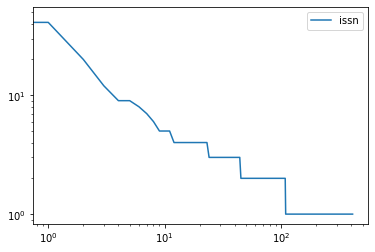

In [312]:
article_data.issn.str.replace('[^\d]', '', regex=True).value_counts().reset_index().plot(loglog=True)

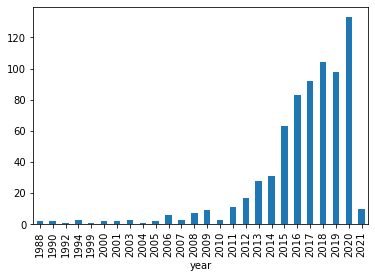

In [313]:
article_data.groupby('year').size().plot.bar()